In [1]:
from sklearn.linear_model import LinearRegression  #used for regression and class
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

In [2]:
path = 'Fish.csv'
df = pd.read_csv(path)
df

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...,...
154,Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936
155,Smelt,13.4,11.7,12.4,13.5,2.4300,1.2690
156,Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558
157,Smelt,19.7,13.2,14.3,15.2,2.8728,2.0672


In [3]:
df.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,26.247170,28.415723,31.227044,8.970994,4.417486
std,357.978317,9.996441,10.716328,11.610246,4.286208,1.685804
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.050000,21.000000,23.150000,5.944800,3.385650
50%,273.000000,25.200000,27.300000,29.400000,7.786000,4.248500
75%,650.000000,32.700000,35.500000,39.650000,12.365900,5.584500
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


In [4]:
df.isnull().sum()

Species    0
Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64

In [5]:
df.duplicated().sum()

np.int64(0)

In [6]:
df.dtypes

Species     object
Weight     float64
Length1    float64
Length2    float64
Length3    float64
Height     float64
Width      float64
dtype: object

In [7]:
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
cat_cols

['Species']

In [8]:
encoding = pd.get_dummies(df, columns=cat_cols, drop_first=True, dtype=int)
df = encoding

In [9]:
df

,Weight,Length1,Length2,Length3,Height,Width,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
0,242.0,23.2,25.4,30.0,11.5200,4.0200,0,0,0,0,0,0
1,290.0,24.0,26.3,31.2,12.4800,4.3056,0,0,0,0,0,0
2,340.0,23.9,26.5,31.1,12.3778,4.6961,0,0,0,0,0,0
3,363.0,26.3,29.0,33.5,12.7300,4.4555,0,0,0,0,0,0
4,430.0,26.5,29.0,34.0,12.4440,5.1340,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
154,12.2,11.5,12.2,13.4,2.0904,1.3936,0,0,0,0,1,0
155,13.4,11.7,12.4,13.5,2.4300,1.2690,0,0,0,0,1,0
156,12.2,12.1,13.0,13.8,2.2770,1.2558,0,0,0,0,1,0
157,19.7,13.2,14.3,15.2,2.8728,2.0672,0,0,0,0,1,0


In [10]:
def detect_outliers_iqr(df, k=1.5):
    """
    Detect columns with outliers using the IQR method.
    Returns a dictionary: {column_name: number_of_outliers}
    """
    outlier_summary = {}
    numeric_cols = df.select_dtypes(include=['int64','float64']).columns
    
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - k * IQR
        upper_bound = Q3 + k * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_count = outliers.shape[0]

        if outlier_count > 0:
            outlier_summary[col] = outlier_count

    return outlier_summary

# Example usage
outlier_columns = detect_outliers_iqr(df)
print("Columns with outliers and their counts:")
print(outlier_columns)

Columns with outliers and their counts:
{'Weight': 3, 'Length1': 3, 'Length2': 3, 'Length3': 1, 'Species_Parkki': 11, 'Species_Pike': 17, 'Species_Roach': 20, 'Species_Smelt': 14, 'Species_Whitefish': 6}


In [11]:
def remove_outliers_iqr(df, k=1.5):
    """
    Remove outliers from all numeric columns using IQR method.
    k = multiplier for IQR (default 1.5).
    Returns a cleaned DataFrame.
    """
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    
    cleaned_df = df.copy()
    
    for col in numeric_cols:
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - k * IQR
        upper_bound = Q3 + k * IQR
        
        # Keep only rows within bounds
        cleaned_df = cleaned_df[(cleaned_df[col] >= lower_bound) & (cleaned_df[col] <= upper_bound)]
    
    return cleaned_df

# ---- Example usage ----
print("Original shape:", df.shape)
df_clean = remove_outliers_iqr(df)
print("After outlier removal:", df_clean.shape)



Original shape: (159, 12)
After outlier removal: (91, 12)


In [13]:
df_clean

,Weight,Length1,Length2,Length3,Height,Width,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
0,242.0,23.2,25.4,30.0,11.5200,4.0200,0,0,0,0,0,0
1,290.0,24.0,26.3,31.2,12.4800,4.3056,0,0,0,0,0,0
2,340.0,23.9,26.5,31.1,12.3778,4.6961,0,0,0,0,0,0
3,363.0,26.3,29.0,33.5,12.7300,4.4555,0,0,0,0,0,0
4,430.0,26.5,29.0,34.0,12.4440,5.1340,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
123,1100.0,39.0,42.0,44.6,12.8002,6.8684,0,1,0,0,0,0
124,1000.0,39.8,43.0,45.2,11.9328,7.2772,0,1,0,0,0,0
125,1100.0,40.1,43.0,45.5,12.5125,7.4165,0,1,0,0,0,0
126,1000.0,40.2,43.5,46.0,12.6040,8.1420,0,1,0,0,0,0


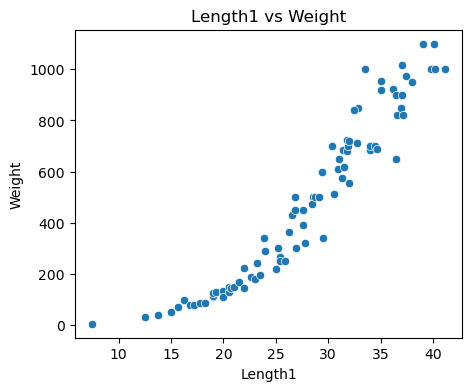

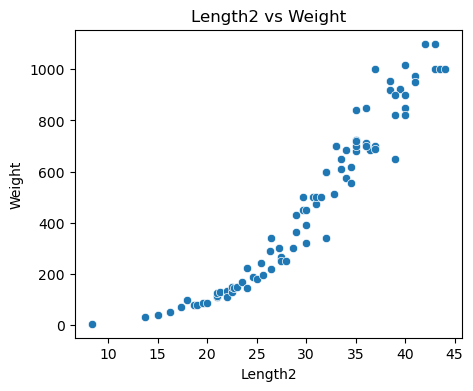

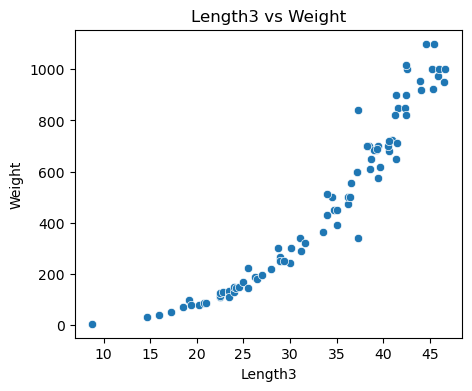

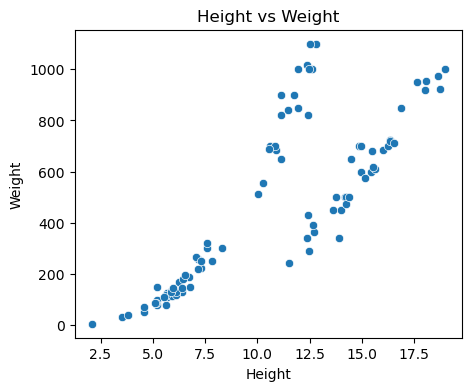

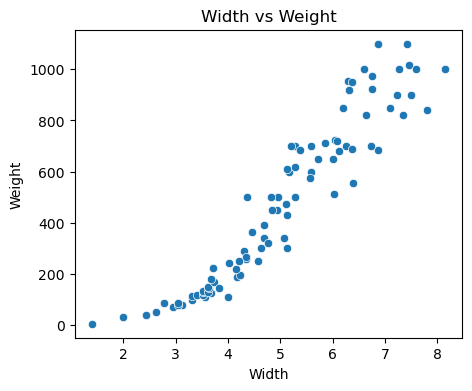

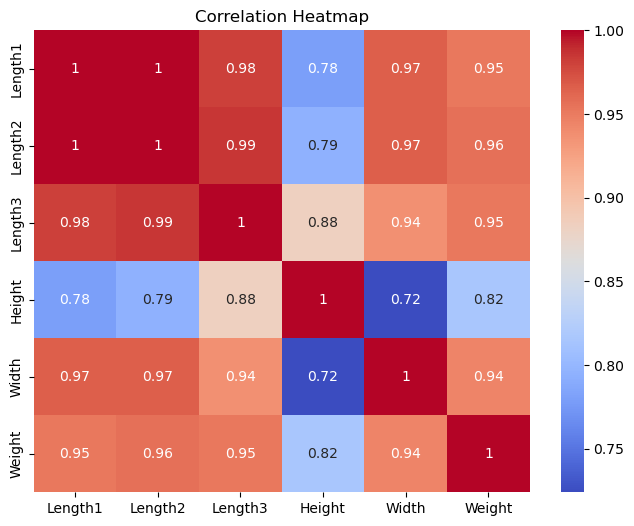

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plots
num_cols = ['Length1','Length2','Length3','Height','Width']
for col in num_cols:
    plt.figure(figsize=(5,4))
    sns.scatterplot(x=df_clean[col], y=df_clean['Weight'])
    plt.title(f"{col} vs Weight")
    plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df_clean[num_cols + ['Weight']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [15]:
df_clean['Len2xWidth'] = df_clean['Length2'] * df_clean['Width']
df_clean['VolumeProxy'] = df_clean['Length3'] * df_clean['Height'] * df_clean['Width']
df_clean['Aspect_L3_H'] = df_clean['Length3'] / df_clean['Height']
df_clean['Aspect_L3_W'] = df_clean['Length3'] / df_clean['Width']


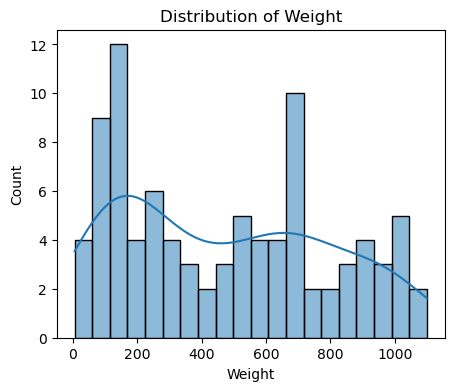

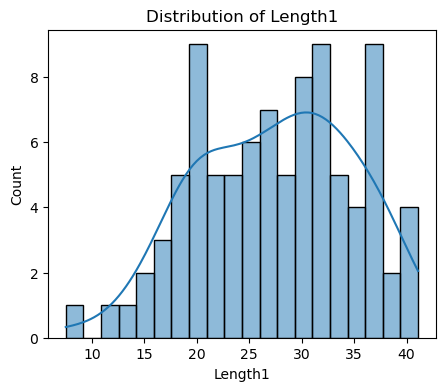

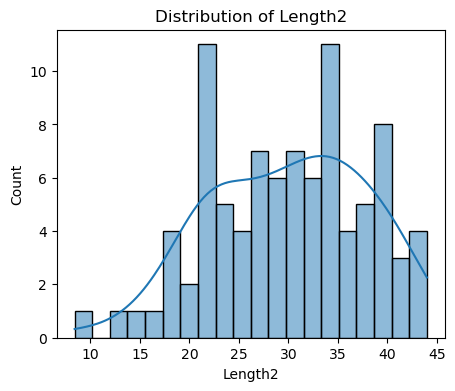

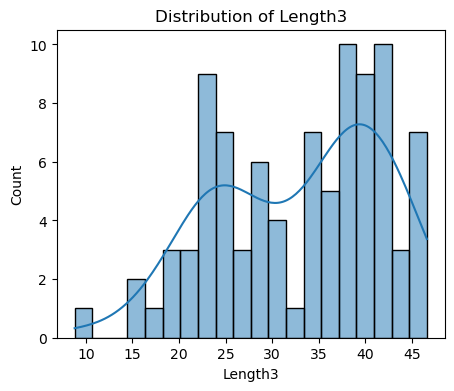

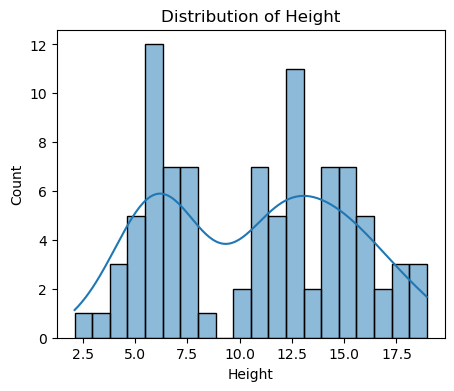

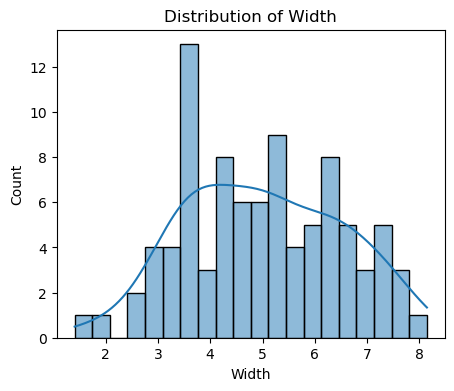

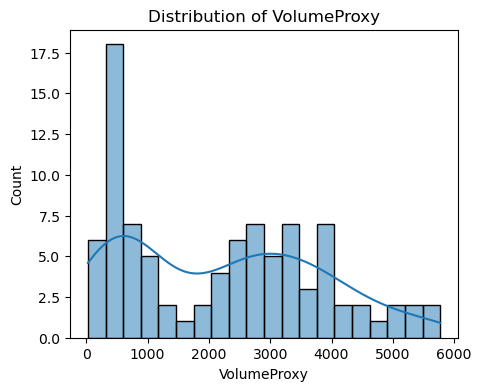

In [16]:
for col in ['Weight','Length1','Length2','Length3','Height','Width','VolumeProxy']:
    plt.figure(figsize=(5,4))
    sns.histplot(df_clean[col], bins=20, kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()


In [17]:
X = df_clean.drop(columns=['Weight'])
y = df_clean['Weight']

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Baseline: Linear Regression

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)
y_pred_lin = linreg.predict(X_test_scaled)

rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
r2_lin = r2_score(y_test, y_pred_lin)

print("Linear Regression -> RMSE:", rmse_lin, " | R²:", r2_lin)


Linear Regression -> RMSE: 38.319450549440184  | R²: 0.9843047030214811


## Ridge Regression

In [21]:
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas=np.logspace(-3, 3, 50))
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

print("Ridge Regression -> RMSE:", rmse_ridge, " | R²:", r2_ridge)
print("Best alpha:", ridge.alpha_)


Ridge Regression -> RMSE: 38.62397141013438  | R²: 0.9840542538860374
Best alpha: 0.022229964825261943


## Lasso Regression

In [22]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(alphas=np.logspace(-3, 1, 50), cv=5, max_iter=5000, random_state=42)
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_test_scaled)

rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

print("Lasso Regression -> RMSE:", rmse_lasso, " | R²:", r2_lasso)
print("Best alpha:", lasso.alpha_)


C:\Users\bbuser\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.277e+02, tolerance: 6.248e+02
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\bbuser\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.803e+02, tolerance: 6.248e+02
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\bbuser\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.885e

Lasso Regression -> RMSE: 39.896190773366826  | R²: 0.9829864925758103
Best alpha: 0.13257113655901082


## Polynomial Regression (degree=2)

In [23]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

linreg_poly = LinearRegression()
linreg_poly.fit(X_train_poly, y_train)
y_pred_poly = linreg_poly.predict(X_test_poly)

rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))
r2_poly = r2_score(y_test, y_pred_poly)

print("Polynomial Regression -> RMSE:", rmse_poly, " | R²:", r2_poly)


Polynomial Regression -> RMSE: 2885.008972182884  | R²: -87.96625866336989


## Compare results in a table

In [24]:
results = pd.DataFrame({
    "Model": ["Linear", "Ridge", "Lasso", "Polynomial (deg=2)"],
    "RMSE": [rmse_lin, rmse_ridge, rmse_lasso, rmse_poly],
    "R²":   [r2_lin, r2_ridge, r2_lasso, r2_poly]
})
print(results)


                Model         RMSE         R²
0              Linear    38.319451   0.984305
1               Ridge    38.623971   0.984054
2               Lasso    39.896191   0.982986
3  Polynomial (deg=2)  2885.008972 -87.966259
